In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from scipy.stats import norm
from sklearn.mixture import GaussianMixture as GMM
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.5
#mpl.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
from src.utils import *
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.cluster import KMeans
# import train test split
from sklearn.model_selection import train_test_split
import pickle


In [2]:
data = {}
sigs = [0.1,0.2,0.5,0.8,0.9,1,1.5,2,5,10]


In [3]:
cd ..

/home/rd804/m-anode


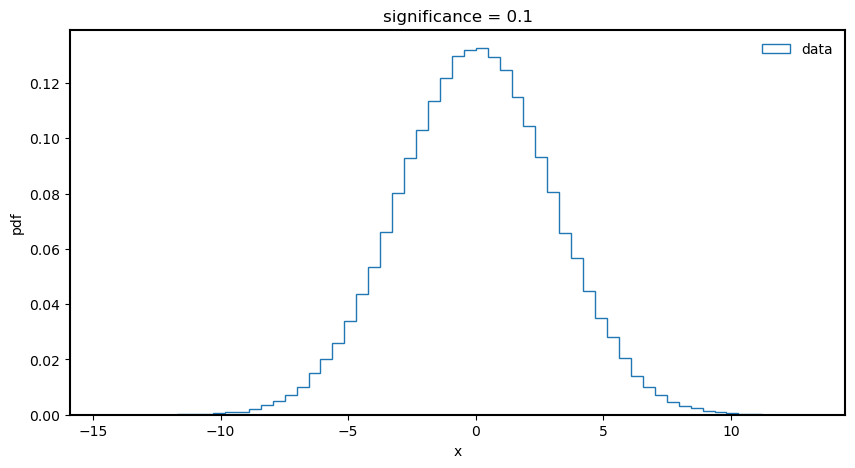

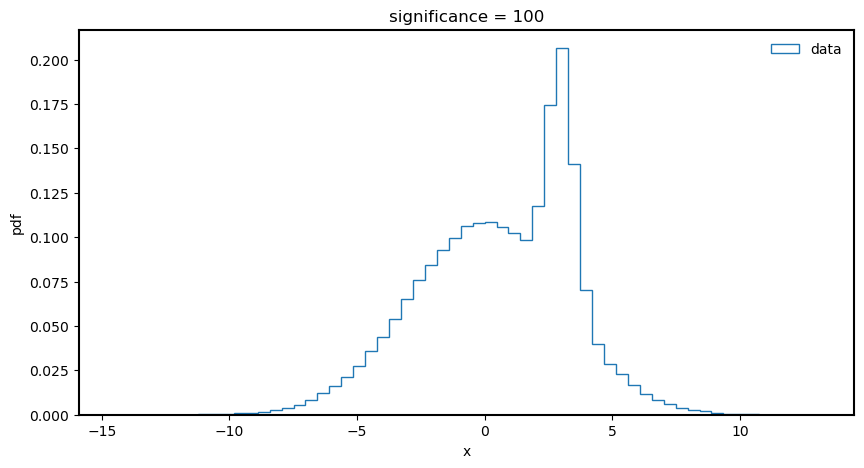

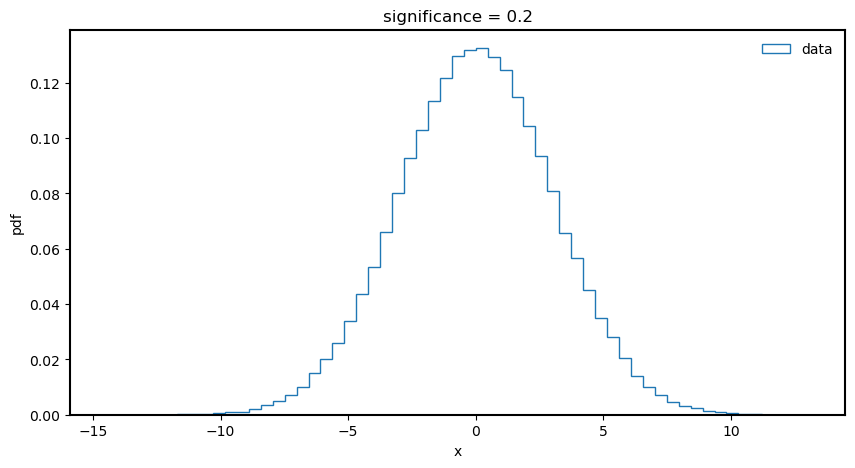

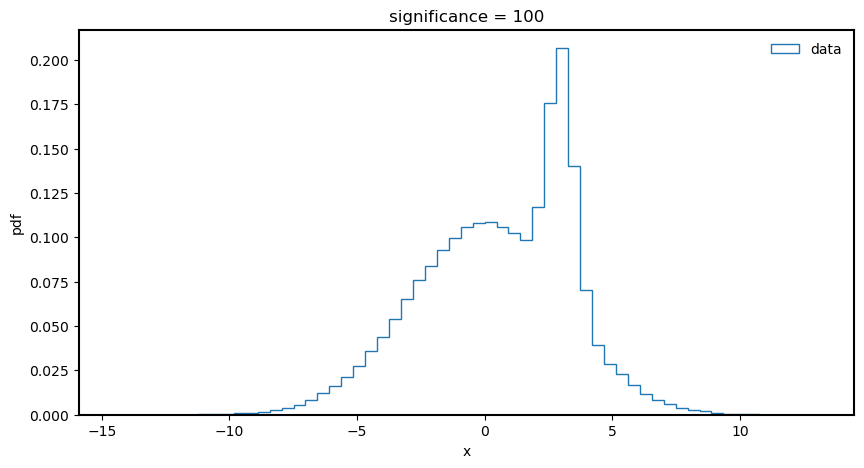

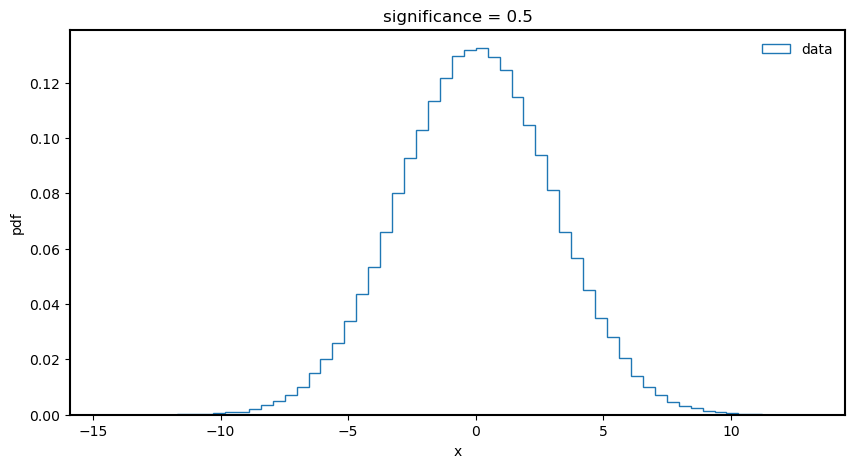

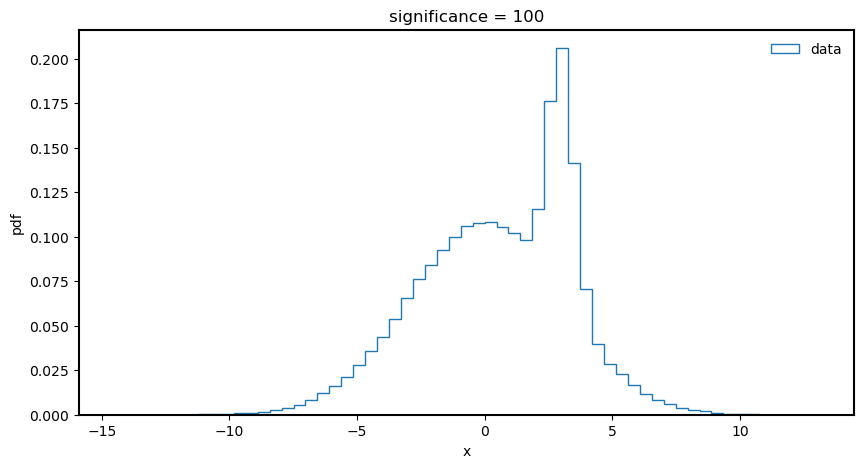

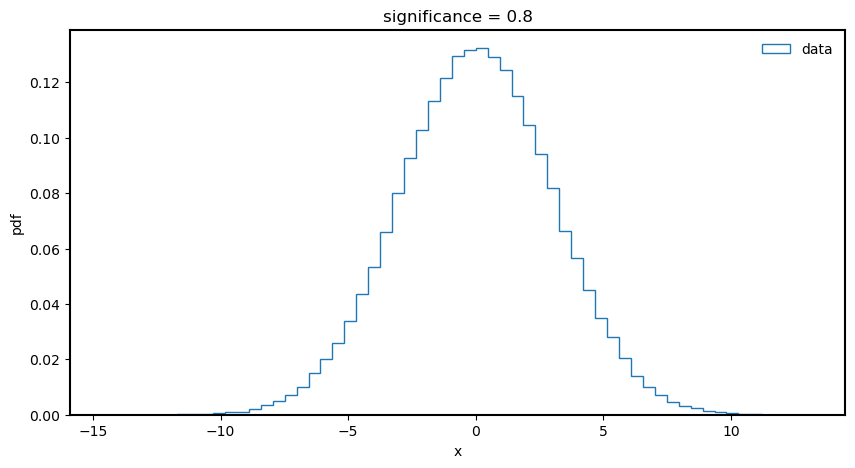

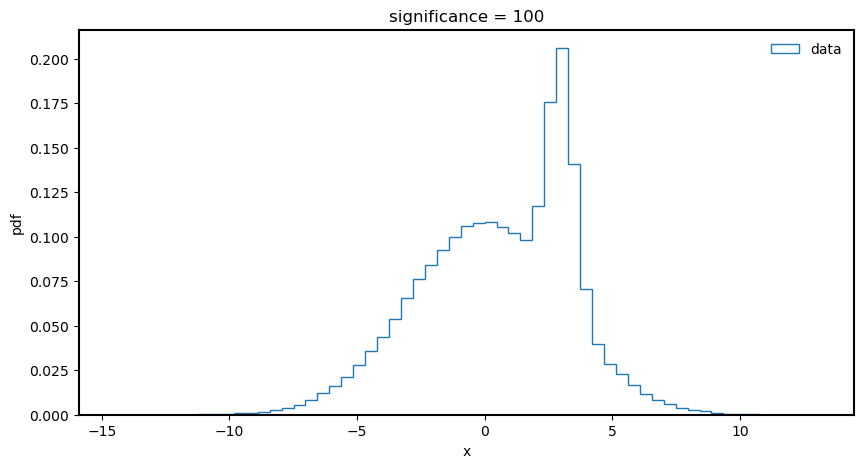

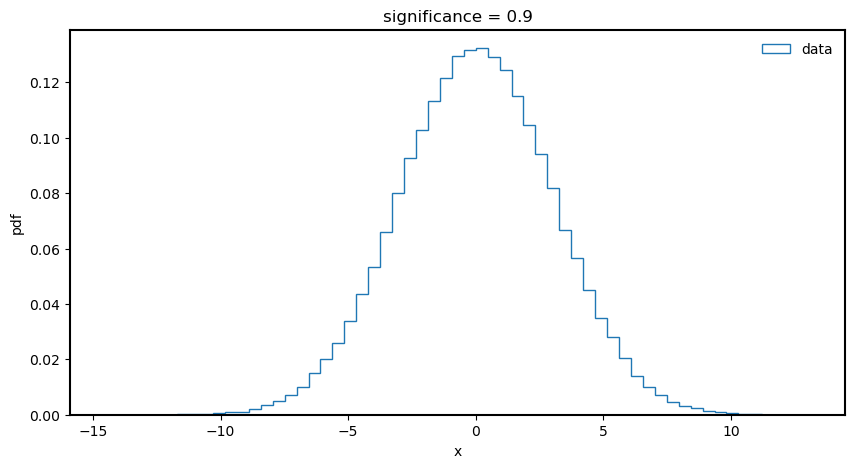

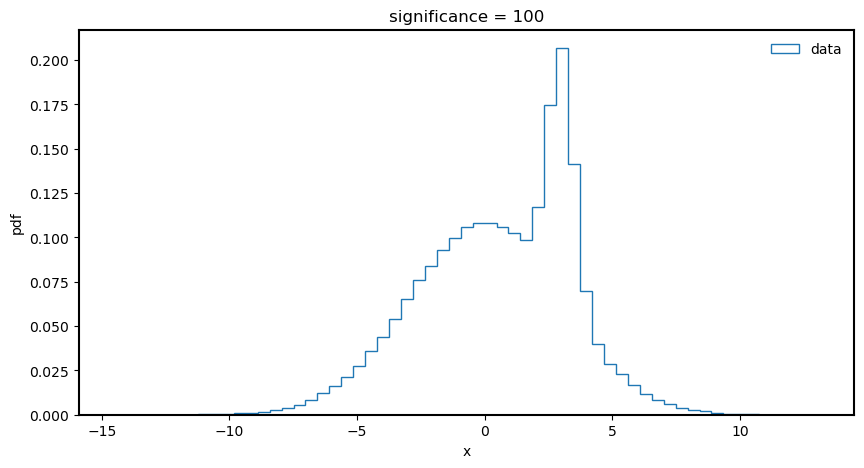

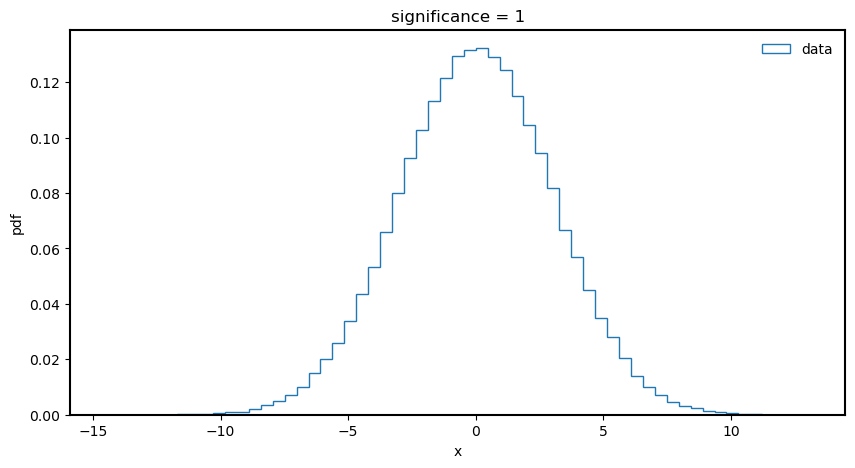

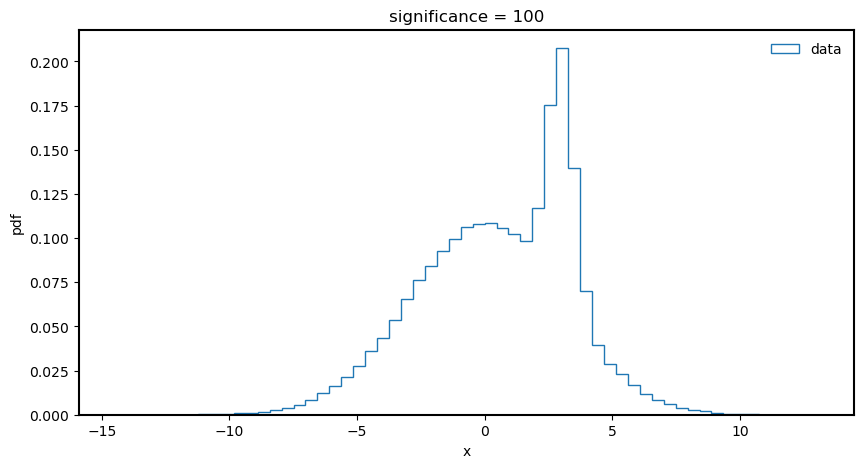

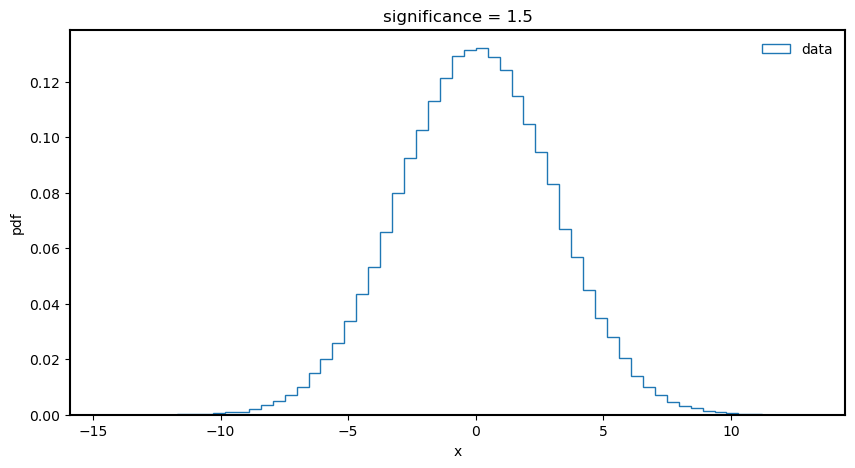

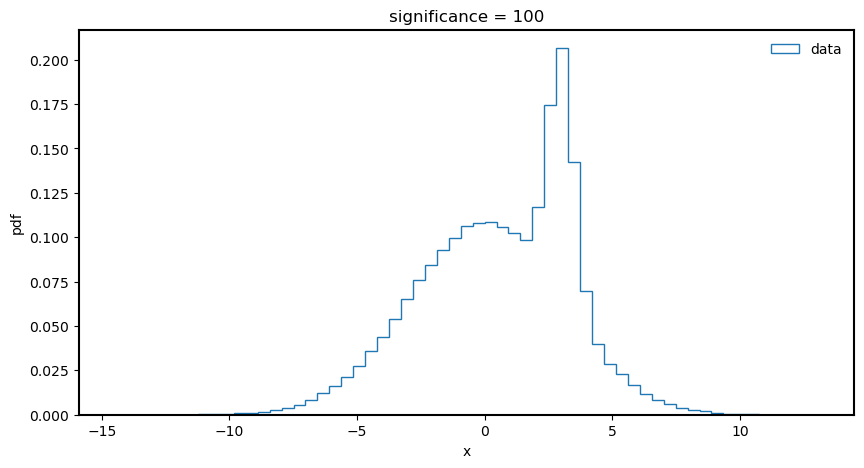

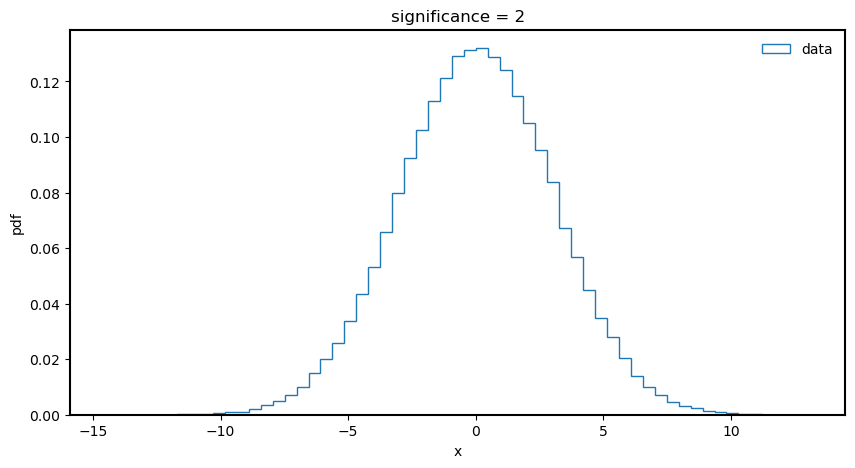

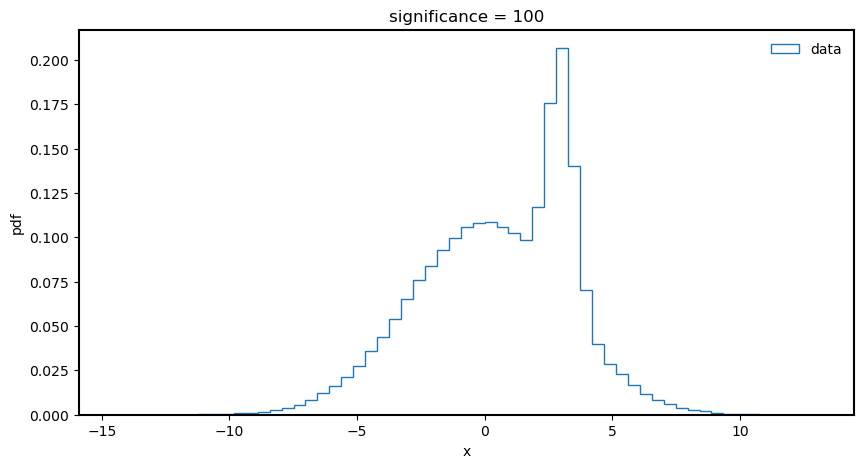

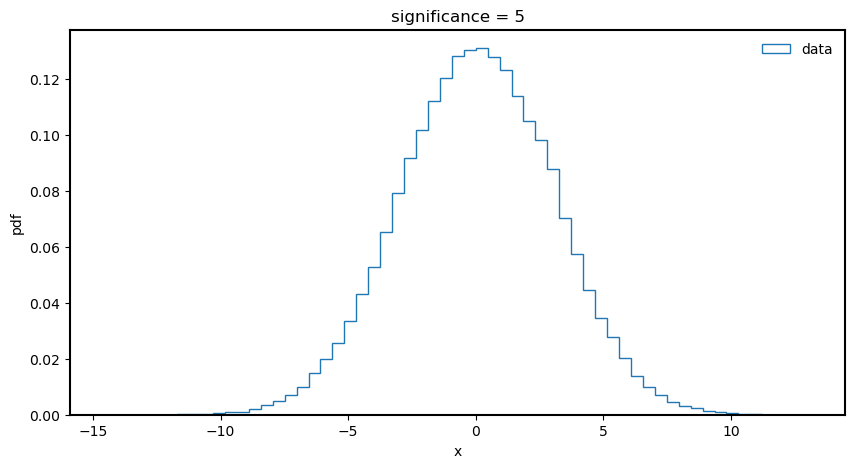

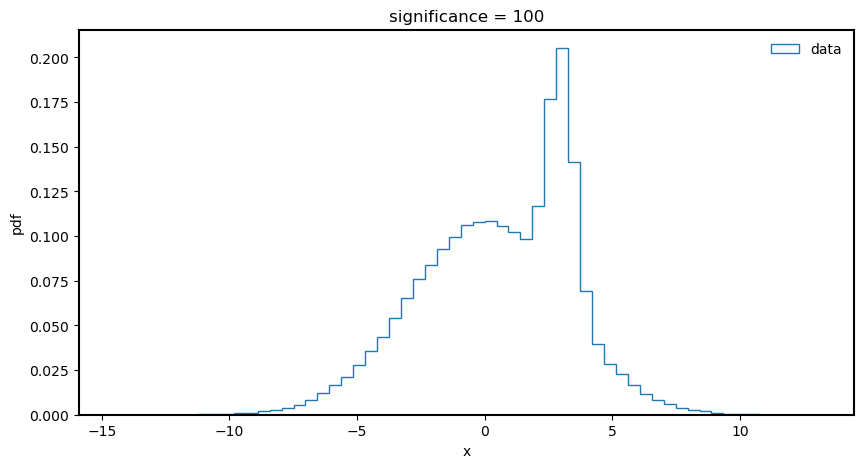

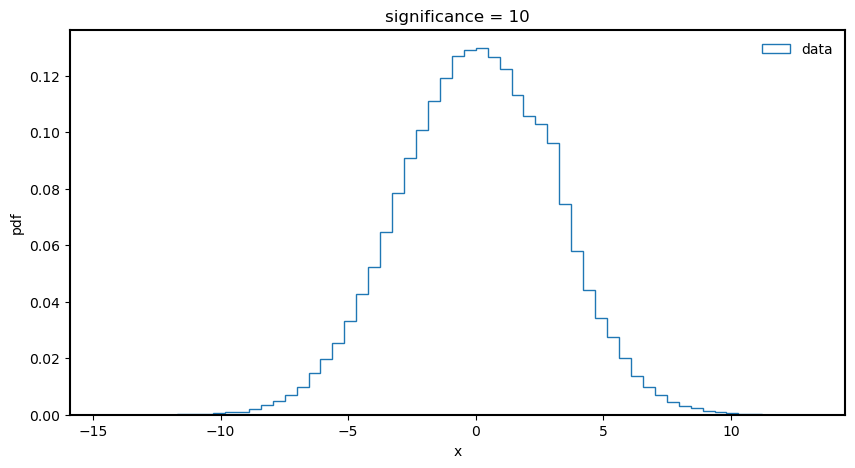

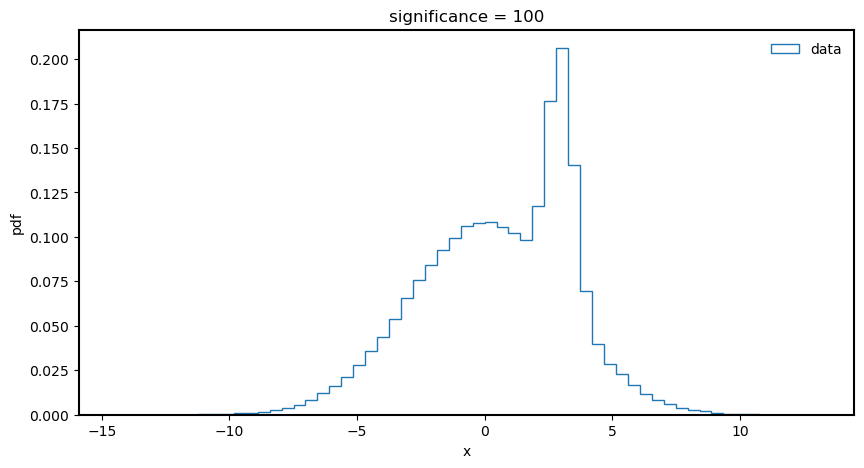

In [4]:
n_back = 200000

back_mean = 0
sig_mean = 3
sig_simga = 0.5
back_sigma = 3

split = ['train','val']
background = np.random.normal(back_mean, back_sigma, n_back)

for sig_train in sigs:


    data[str(sig_train)] = {}

    for s in split:


        if s == 'val':
            significance = 100
        else:
            significance = sig_train

        n_signal = int(np.sqrt(n_back) * significance)
        signal = np.random.normal(sig_mean, sig_simga, n_signal)
        x = np.concatenate([background, signal])
        label = np.concatenate([np.zeros(len(background)), np.ones(len(signal))])


        data[str(sig_train)][s] = {}

        data[str(sig_train)][s]['label'] = label
        data[str(sig_train)][s]['data'] = x

        bins = np.linspace(min(x.flatten()), max(x.flatten()), 60)

        plt.subplots(figsize=(10, 5))
        plt.hist(x.flatten(), bins=bins, density=True, histtype='step', label='data')
       
        plt.title('significance = {}'.format(significance))
        plt.legend(frameon=False)
        plt.xlabel('x')
        plt.ylabel('pdf')
        plt.show()

In [7]:
# save data to h5 file

import h5py

with h5py.File('data/data.h5', 'w') as f:
    for sig_train in sigs:
        for s in split:
            f.create_dataset('sig_train_{}/{}'.format(sig_train, s), data=data[str(sig_train)][s]['data'])
            f.create_dataset('label_{}/{}'.format(sig_train, s), data=data[str(sig_train)][s]['label'])


In [19]:
# save data to pickle file

with open('data/data.pkl', 'wb') as f:
    pickle.dump(data, f)
  

[0.1, 0.2, 0.5, 0.8, 0.9, 1, 1.5, 2, 5, 10]
0.1


/tmp/ipykernel_699876/1161027462.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_signal = int(np.sqrt(n_back) * np.float(sig_train))


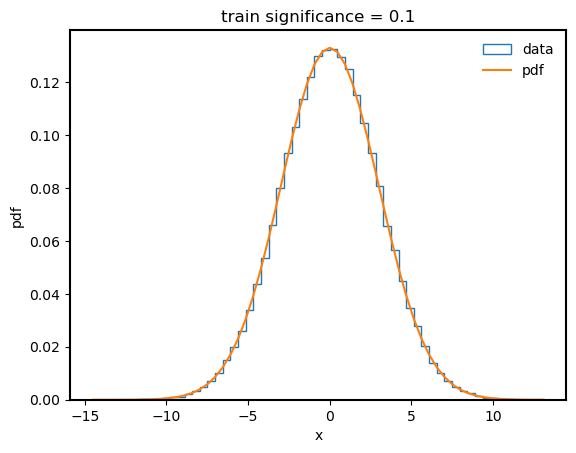

0.2


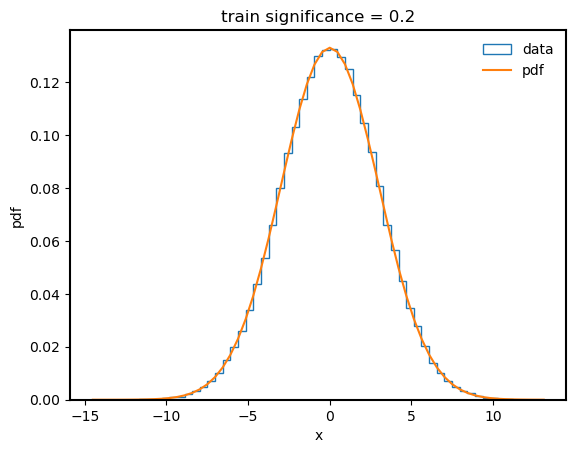

0.5


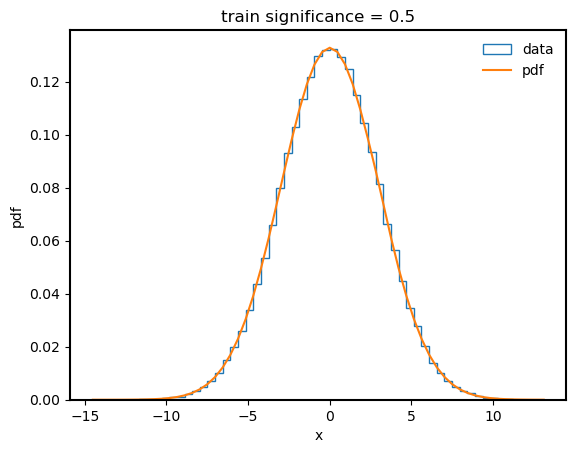

0.8


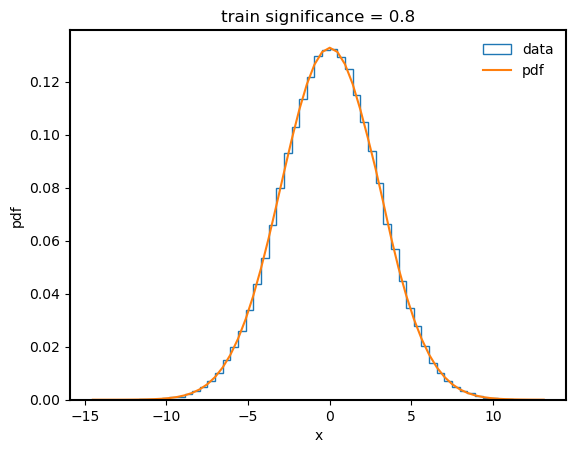

0.9


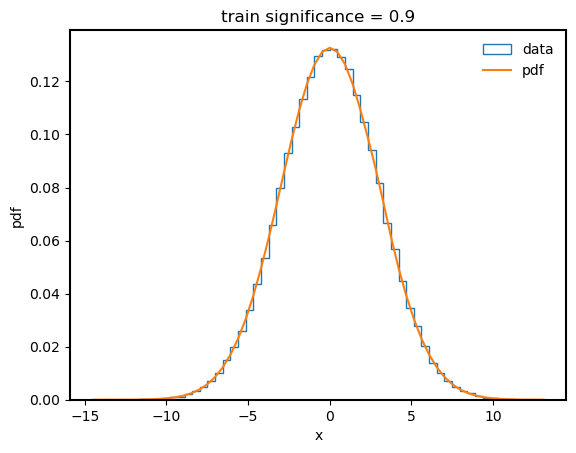

1


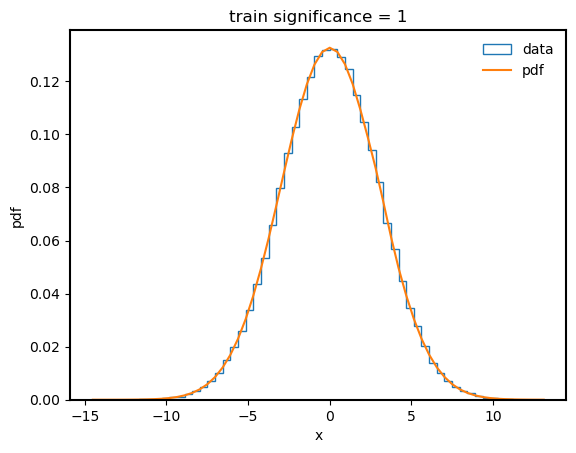

1.5


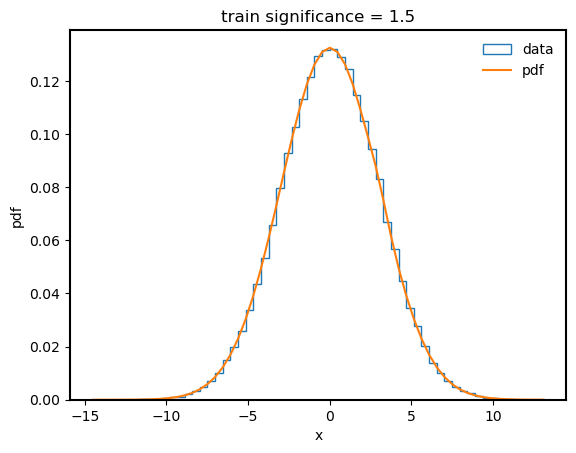

2


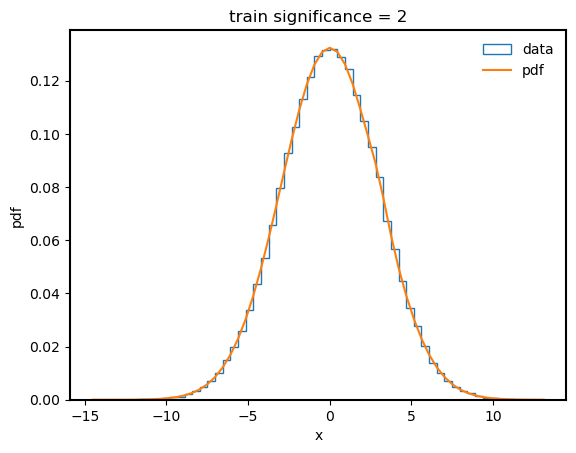

5


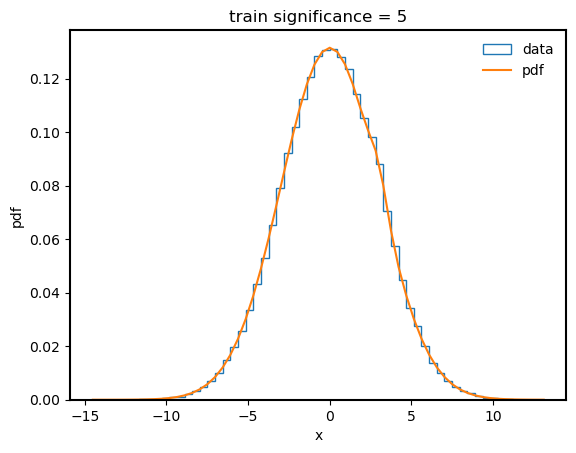

10


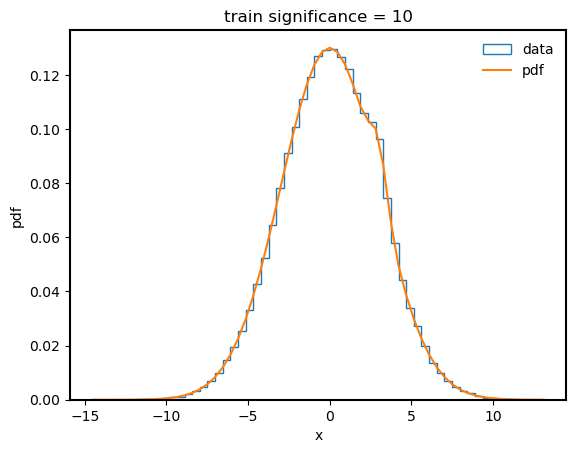

In [8]:
true_w = {}
print(sigs)
for sig_train in sigs:

    x_train = data[str(sig_train)]['train']['data']
    print(sig_train)
    bins = np.linspace(min(x_train.flatten()), max(x_train.flatten()), 60)

    n_signal = int(np.sqrt(n_back) * np.float(sig_train))
    w1 = n_signal / (n_signal + n_back)
    w2 = 1 - w1

    true_w[str(sig_train)] = [w1,w2]


    mu1 = sig_mean
    mu2 = back_mean
    sigma1 = sig_simga
    sigma2 = back_sigma



    plt.hist(x_train.flatten(), bins=bins, density=True, histtype='step', label='data')
    plt.plot(bins, w1 * norm.pdf(bins, mu1, sigma1) + w2 * norm.pdf(bins, mu2, sigma2), label='pdf')
    plt.title('{} significance = {}'.format('train',sig_train))
    plt.legend(frameon=False)
    plt.xlabel('x')
    plt.ylabel('pdf')
    plt.show()

In [20]:
# save true weights to h5 file

with h5py.File('results/true_w.h5', 'a') as f:
    for sig_train in sigs:
        f.create_dataset('true_w_{}'.format(sig_train), data=true_w[str(sig_train)])



OSError: Unable to create file (unable to open file: name = 'results/true_w.h5', errno = 17, error message = 'File exists', flags = 15, o_flags = c2)

In [21]:
# save true weights to pickle file

with open('results/true_w.pkl', 'wb') as f:
    pickle.dump(true_w, f)

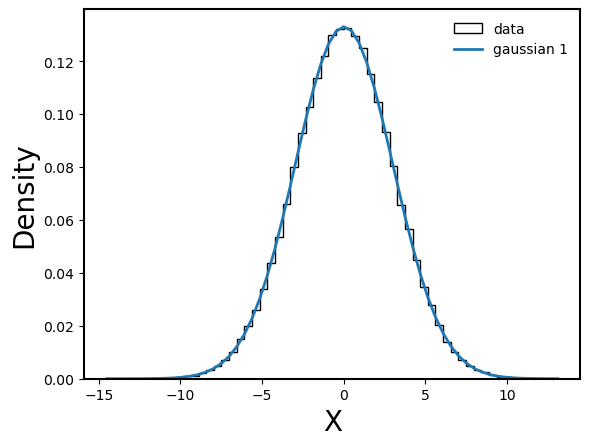

In [10]:
# Fit background only
x_train = data[str(sig_train)]['train']['data']
y_train = data[str(sig_train)]['train']['label']

x_b = x_train[y_train == 0].reshape(-1, 1)

bins = np.linspace(min(x_b.flatten()), max(x_b.flatten()), 60)
# Since the optimal value is n=2 according to both BIC and AIC, let's write down:
n_optimal = 1

# create GMM model object
gmm = GMM(n_components = n_optimal, max_iter=1000, random_state=10, covariance_type = 'full')

# find useful parameters
mean = gmm.fit(x_b).means_  
covs  = gmm.fit(x_b).covariances_
weights = gmm.fit(x_b).weights_

# create necessary things to plot
x_axis = bins
y_axis0 = norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
#y_axis1 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[1][0][0])))*weights[1] # 2nd gaussian

# Plot 2
plt.hist(x_b, density=True, color='black', bins=bins, histtype='step',
         label='data')
plt.plot(x_axis, y_axis0, lw=2, c='C0', label='gaussian 1')
plt.xlabel(r"X", fontsize=20)
plt.ylabel(r"Density", fontsize=20)

plt.subplots_adjust(wspace=0.3)
plt.legend(frameon=False)
plt.show()
plt.close('all')

mu_background = float(mean[0][0])
sigma_background = float(covs[0][0][0])

In [11]:
# save background only fit to h5 file

with h5py.File('results/background_only_fit.h5', 'w') as f:
    f.create_dataset('mu_background', data=mu_background)
    f.create_dataset('sigma_background', data=sigma_background)

In [22]:
# save as pickle file

with open('results/background_only_fit.pkl', 'wb') as f:
    pickle.dump([mu_background, sigma_background], f)

In [23]:
sigs = [1.5,2,5,10,0.1,0.2,0.5,0.8,0.9,1]


In [24]:
# fit train data
best_parameters = {}
run = 0

for sig_train in sigs:
    best_parameters[str(sig_train)] = {}
    x_train = data[str(sig_train)]['train']['data']

    print('#################################')
    print('#################################')
    print('#################################')
    print('---------------------------------')





    for run in range(10):


        best_parameters[str(sig_train)][str(run)] = {}

        print('#################################')
        print
        print('Running EM algorithm for sig = {}'.format(sig_train))
        n_optimal = 2
        trial = 0
        best_likelihood = -np.inf
        convergence_ = False

        while convergence_ != True:
            trial += 1
            convergence_ ,mu_data , sigma_data, w_data, like_arr = EM_2_gaussian(x_train, n_optimal, 1000, 
                                                                                1e-32,
                                                            init_params='random',
                                                            mu_back=mu_background,
                                                            sigma_back=sigma_background)
            
            max_likelihood = np.argmax(like_arr)


            mu_ = mu_data[max_likelihood]
            sigma_ = sigma_data[max_likelihood]
            w_ = w_data[max_likelihood]
            x_axis = bins

        

            if like_arr[max_likelihood] > best_likelihood:
                best_likelihood = like_arr[max_likelihood]
                best_mu = mu_
                best_sigma = sigma_
                best_w = w_
                best_trial = trial
                best_like_arr = like_arr


                best_parameters[str(sig_train)][str(run)]['mu'] = best_mu
                best_parameters[str(sig_train)][str(run)]['sigma'] = best_sigma
                best_parameters[str(sig_train)][str(run)]['w'] = best_w
                

            if trial > 100:
                break

        if convergence_ == True:
            print('Converged after {} trials'.format(trial))
            print('Best trial was {}'.format(best_trial))

            best_parameters[str(sig_train)][str(run)]['converged_mu'] = mu_
            best_parameters[str(sig_train)][str(run)]['converged_sigma'] = sigma_
            best_parameters[str(sig_train)][str(run)]['converged_w'] = w_

        else:
            print('Did not converge after {} trials'.format(trial))
            print('Best trial was {}'.format(best_trial))

        
        # save best parameters to pickle file

        with open(f'results/best_parameters.pkl', 'wb') as f:
            pickle.dump(best_parameters, f)

        with open(f'results/best_parameters_sig_{sig_train}.pkl', 'wb') as f:
            pickle.dump(best_parameters[str(sig_train)], f)

            


    





#################################
#################################
#################################
---------------------------------
#################################
Running EM algorithm for sig = 1.5
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Converged after 504 iterations.
Converged after 8 trials
Best trial was 6
#################################
Running EM algorithm for sig = 1.5
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Converged after 482 iterations.
Converged after 9 trials
Best trial

/home/rd804/m-anode/src/utils.py:122: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(p_c1 + p_c2).sum()
/home/rd804/m-anode/src/utils.py:30: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 99

Traceback (most recent call last):
  File "/home/rd804/.conda/envs/manode/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_699876/374075983.py", line 33, in <module>
    convergence_ ,mu_data , sigma_data, w_data, like_arr = EM_2_gaussian(x_train, n_optimal, 1000,
  File "/home/rd804/m-anode/src/utils.py", line 120, in EM_2_gaussian
  File "/home/rd804/.conda/envs/manode/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py", line 2098, in pdf
    putmask(output, (1-cond0)+np.isnan(x), self.badvalue)
  File "<__array_function__ internals>", line 180, in putmask
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/rd804/.conda/envs/manode/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  F

OSError: Unable to create file (unable to open file: name = 'results/best_parameters.h5', errno = 17, error message = 'File exists', flags = 15, o_flags = c2)

In [69]:
# update h5 file with best parameters

       

[-1.86760772e-03  2.97881302e+00]
[9.01797806 0.23830317]
[0.97731884 0.02268116]


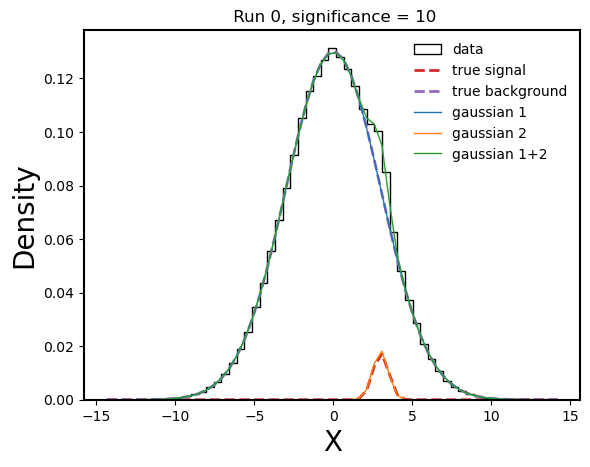

[-1.86798438e-03  2.97881219e+00]
[9.01797809 0.23830638]
[0.9773187 0.0226813]


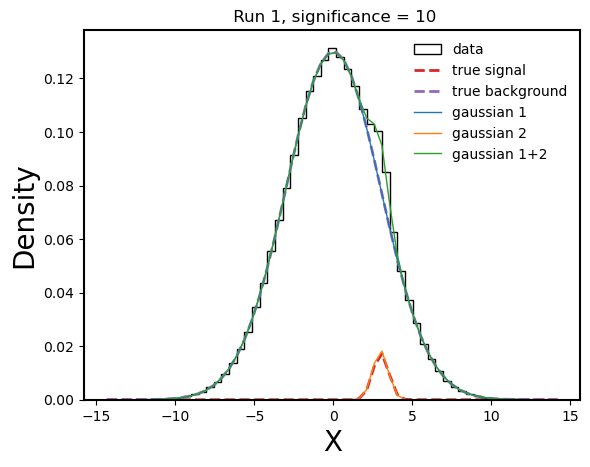

[ 2.97881217e+00 -1.86799348e-03]
[0.23830646 9.01797809]
[0.0226813 0.9773187]


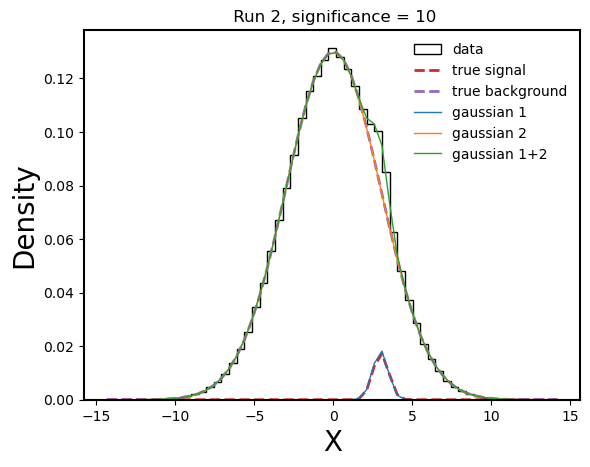

[-1.86759210e-03  2.97881305e+00]
[9.01797806 0.23830304]
[0.97731884 0.02268116]


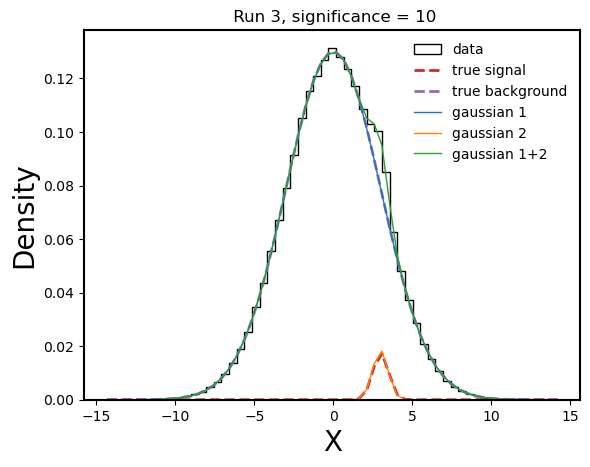

[ 2.97881201e+00 -1.86806364e-03]
[0.23830706 9.0179781 ]
[0.02268132 0.97731868]


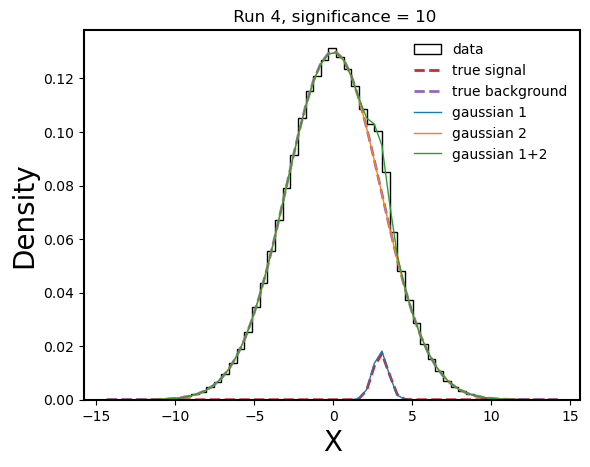

[ 2.97881305e+00 -1.86759321e-03]
[0.23830305 9.01797806]
[0.02268116 0.97731884]


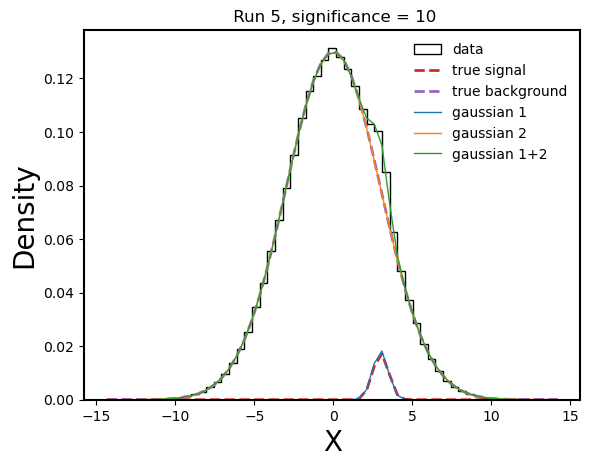

[-1.86755871e-03  2.97881313e+00]
[9.01797806 0.23830275]
[0.97731885 0.02268115]


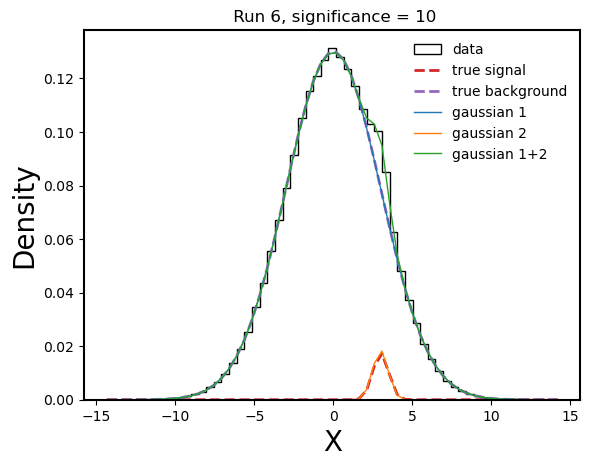

[-1.86803871e-03  2.97881207e+00]
[9.01797809 0.23830684]
[0.97731868 0.02268132]


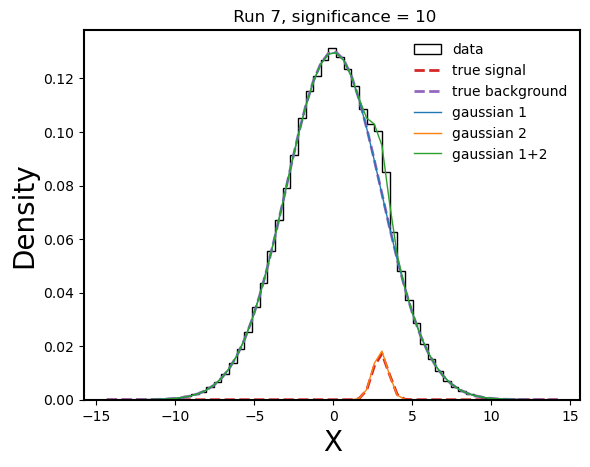

[-1.19537541  1.29429493]
[7.8533977  7.08946091]
[0.49346182 0.50653818]


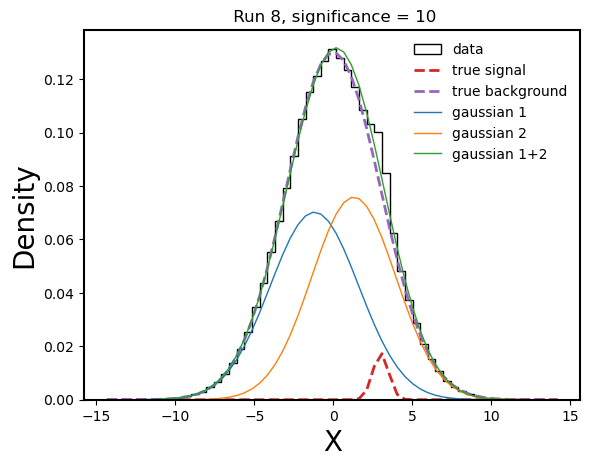

[-1.86754487e-03  2.97881316e+00]
[9.01797806 0.23830264]
[0.97731886 0.02268114]


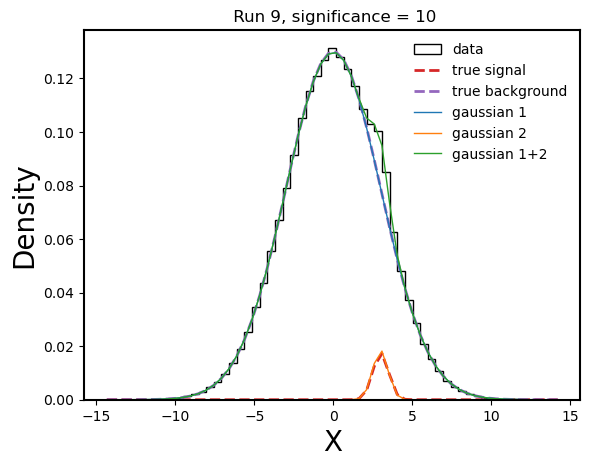

In [32]:
run = 0 





for sig_train in [10]:

    for run in range(10):

        x_train = data[str(sig_train)]['train']['data']
        bins = np.linspace(min(x_train.flatten()), max(x_train.flatten()), 60)

        w1 = true_w[str(sig_train)][0]
        w2 = true_w[str(sig_train)][1]
        true_sig = norm.pdf(x_axis, sig_mean, sig_simga)*w1
        true_back = norm.pdf(x_axis, back_mean, back_sigma)*w2

        mu_ = best_parameters[str(sig_train)][str(run)]['mu']
        sigma_ = best_parameters[str(sig_train)][str(run)]['sigma']
        w_ = best_parameters[str(sig_train)][str(run)]['w']
        print(mu_)
        print(sigma_)
        print(w_)
        plt.hist(x_train, density=True, color='black', bins=bins, histtype='step',
                    label='data')
        plt.plot(x_axis, true_sig, lw=2, c='C3', label='true signal',ls='--')
        plt.plot(x_axis, true_back, lw=2, c='C4', label='true background', ls='--')
        plt.plot(x_axis, w_[0] * norm.pdf(x_axis, mu_[0], np.sqrt(sigma_[0])), lw=1, c='C0', label='gaussian 1')
        plt.plot(x_axis, w_[1] * norm.pdf(x_axis, mu_[1], np.sqrt(sigma_[1])), lw=1, c='C1', label='gaussian 2')
        plt.plot(x_axis, w_[0] * norm.pdf(x_axis, mu_[0], np.sqrt(sigma_[0])) + w_[1] * norm.pdf(x_axis, mu_[1], np.sqrt(sigma_[1])), lw=1, c='C2', label='gaussian 1+2')
        plt.title(' Run {}, significance = {}'.format(run,sig_train))
        plt.xlabel(r"X", fontsize=20)
        plt.ylabel(r"Density", fontsize=20)
        plt.legend(frameon=False)
        plt.show()

In [27]:
best_parameters['100'][str(1)]

{'mu': array([ 3.00398832e+00, -2.86345504e-03]),
 'sigma': array([0.25167496, 9.01520569]),
 'w': array([0.18357597, 0.81642403]),
 'converged_mu': array([ 3.00398832e+00, -2.86345504e-03]),
 'converged_sigma': array([0.25167496, 9.01520569]),
 'converged_w': array([0.18357597, 0.81642403])}

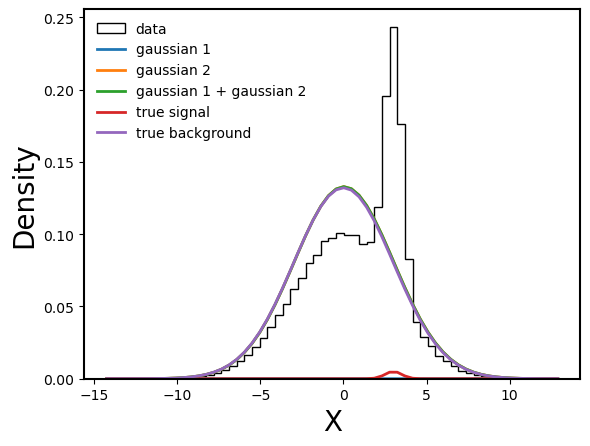

In [13]:
x_val = data[str(sig_train)]['val']['data']
label_val = data[str(sig_train)]['val']['label']

bins = np.linspace(min(x_val.flatten()), max(x_val.flatten()), 60)
max_likelihood = np.argmax(like_arr)

mu_ = mu_data[max_likelihood]
sigma_ = sigma_data[max_likelihood]
w_ = w_data[max_likelihood]
x_axis = bins

true_sig = norm.pdf(x_axis, mu1, sigma1)*w1
true_back = norm.pdf(x_axis, mu2, sigma2)*w2

plt.hist(x_val, density=True, color='black', bins=bins, histtype='step',
            label='data')
plt.plot(x_axis, norm.pdf(x_axis, mu_[0], np.sqrt(sigma_[0]))*w_[0], lw=2, c='C0', label='gaussian 1')
plt.plot(x_axis, norm.pdf(x_axis, mu_[1], np.sqrt(sigma_[1]))*w_[1], lw=2, c='C1', label='gaussian 2')
plt.plot(x_axis, norm.pdf(x_axis, mu_[0], np.sqrt(sigma_[0]))*w_[0] + norm.pdf(x_axis, mu_[1], np.sqrt(sigma_[1]))*w_[1], lw=2, c='C2', label='gaussian 1 + gaussian 2')
plt.plot(x_axis, true_sig, lw=2, c='C3', label='true signal')
plt.plot(x_axis, true_back, lw=2, c='C4', label='true background')
plt.xlabel(r"X", fontsize=20)
plt.ylabel(r"Density", fontsize=20)
plt.legend(frameon=False)
plt.show()

In [55]:
score_likelihoods = {}
true_likelihoods = {}

for sig_train in [10]:
    score_likelihoods[str(sig_train)] = {}
    true_likelihoods[str(sig_train)] = {}

    x_val = data[str(sig_train)]['val']['data']
    label_val = data[str(sig_train)]['val']['label']

    w1 = true_w[str(sig_train)][0]
    w2 = true_w[str(sig_train)][1]

    true_likelihoods[str(sig_train)] = p_data(x_val,[sig_mean, back_mean],[sig_simga**2,back_sigma**2],[w1,w2])/p_back(x_val,back_mean,back_sigma**2)

    
    for run in range(10):
        score_likelihoods[str(sig_train)][str(run)] = p_data(x_val,mu,sigma,w)/p_back(x_val,mu_background,sigma_background)



        mu = best_parameters[str(sig_train)][str(run)]['mu']
        sigma = best_parameters[str(sig_train)][str(run)]['sigma']
        w = best_parameters[str(sig_train)][str(run)]['w']




 




/home/rd804/m-anode/src/utils.py:12: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:12: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:12: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:12: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:12: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:12: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:12: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:12: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:12: RuntimeWarning: invalid value encountered in divid

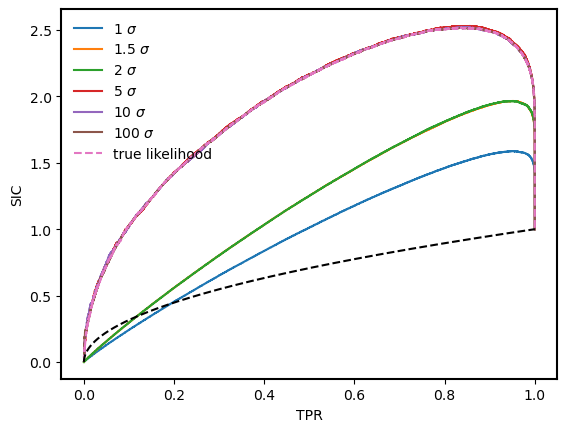

In [14]:

for sig_train in sigs:
    sic , tpr , auc = SIC(label_val, score_likelihoods[str(sig_train)])
    sic_true , tpr_true , auc_true = SIC(label_val, true_likelihoods[str(sig_train)])

    plt.plot(tpr, sic, label=f'{sig_train} $\sigma$')
plt.plot(tpr_true, sic_true, label='true likelihood', ls='--')
plt.xlabel('TPR')
plt.ylabel('SIC')
plt.legend(frameon=False)
plt.plot(tpr_true, tpr_true**0.5, label='random', color='black', ls='--')

plt.show()


In [ ]:
def SIC_fpr(label, score, fpr_target):
    fpr, tpr, thresholds = roc_curve(label, score)

    index = np.argmin(np.abs(fpr - fpr_target))

    sic = tpr/np.sqrt(fpr)

    sic_target = sic[index]

    return sic_target



def SIC(label, score):
    fpr, tpr, thresholds = roc_curve(label, score)
    auc = roc_auc_score(label, score)

    tpr = tpr[fpr>0]
    fpr = fpr[fpr>0]

    sic = tpr/np.sqrt(fpr)

    return sic, tpr, auc

In [57]:
summary = {}
for sig_train in [10]:

    label_val = data[str(sig_train)]['val']['label']
    summary[str(sig_train)] = {}


    sic_true , tpr_true , auc_true = SIC(label_val, true_likelihoods[str(sig_train)])
    sic_01 = SIC_fpr(label_val, true_likelihoods[str(sig_train)], 0.01)
    sic_001 = SIC_fpr(label_val, true_likelihoods[str(sig_train)], 0.001)
    
    # true summaries
    summary[str(sig_train)]['true max sic'] = np.amax(sic_true)
    summary[str(sig_train)]['true auc'] = auc_true
    summary[str(sig_train)]['true sic_0.01'] = sic_01
    summary[str(sig_train)]['true sic_0.001'] = sic_001

    max_sic_array = []
    auc_array = []
    sic_01_array = []
    sic_001_array = []

    for run in range(10):
        sic , tpr , auc = SIC(label_val, score_likelihoods[str(sig_train)][str(run)])
        sic_01 = SIC_fpr(label_val, score_likelihoods[str(sig_train)][str(run)], 0.01)
        sic_001 = SIC_fpr(label_val, score_likelihoods[str(sig_train)][str(run)], 0.001)

        max_sic_array.append(np.amax(sic))
        auc_array.append(auc)
        sic_01_array.append(sic_01)
        sic_001_array.append(sic_001)

    summary[str(sig_train)]['max sic'] = max_sic_array
    summary[str(sig_train)]['auc'] = auc_array
    summary[str(sig_train)]['sic_0.01'] = sic_01_array
    summary[str(sig_train)]['sic_0.001'] = sic_001_array
    

/tmp/ipykernel_688458/3337297680.py:6: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_688458/3337297680.py:6: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_688458/3337297680.py:6: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_688458/3337297680.py:6: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_688458/3337297680.py:6: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_688458/3337297680.py:6: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_688458/3337297680.py:6: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_688458/3337297680.py:6: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/tmp/ipykernel_688458/3337297680.py:6: RuntimeWarning: invalid value e

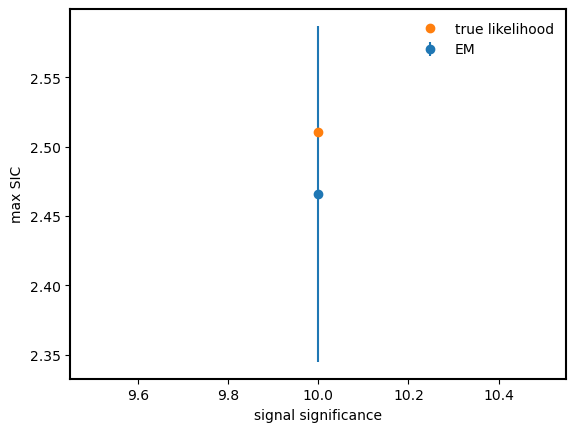

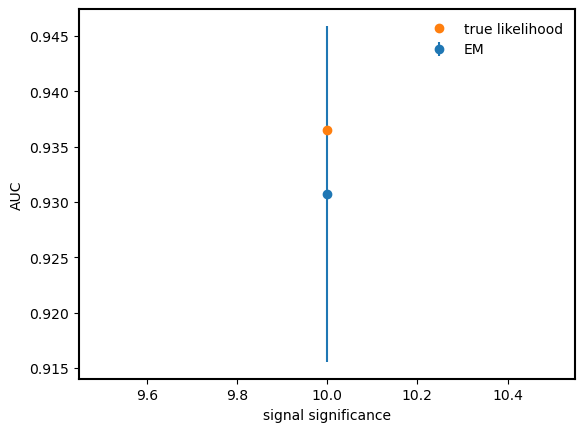

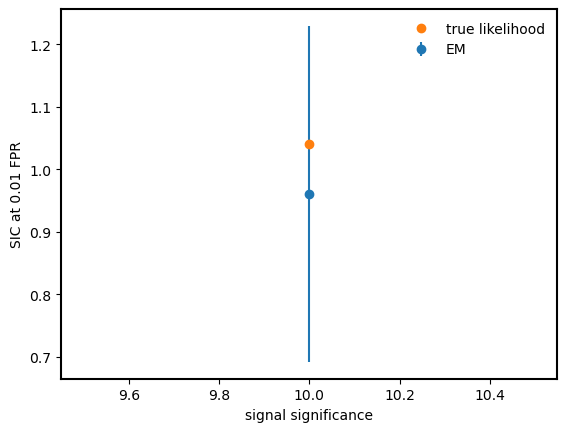

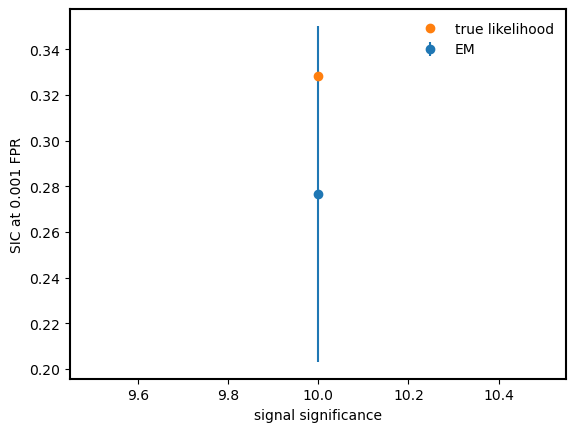

In [59]:
sig_ = [10]

for sig_train in sig_:
    true_max_sic = summary[str(sig_train)]['true max sic']
    max_sic_mean = np.mean(summary[str(sig_train)]['max sic'])
    max_sic_std = np.std(summary[str(sig_train)]['max sic'])

    true_auc = summary[str(sig_train)]['true auc']
    auc_mean = np.mean(summary[str(sig_train)]['auc'])
    auc_std = np.std(summary[str(sig_train)]['auc'])

    true_sic_01 = summary[str(sig_train)]['true sic_0.01']
    sic_01_mean = np.mean(summary[str(sig_train)]['sic_0.01'])
    sic_01_std = np.std(summary[str(sig_train)]['sic_0.01'])

    true_sic_001 = summary[str(sig_train)]['true sic_0.001']
    sic_001_mean = np.mean(summary[str(sig_train)]['sic_0.001'])
    sic_001_std = np.std(summary[str(sig_train)]['sic_0.001'])

# plot max sic vs sig_ with error bars

    plt.errorbar(sig_train, max_sic_mean, yerr=max_sic_std, fmt='o', label='EM')
    plt.plot(sig_train, true_max_sic, 'o', label='true likelihood')
    plt.xlabel('signal significance')
    plt.ylabel('max SIC')
    plt.legend(frameon=False)
    plt.show()

# plot auc vs sig_ with error bars

    plt.errorbar(sig_train, auc_mean, yerr=auc_std, fmt='o', label='EM')
    plt.plot(sig_train, true_auc, 'o', label='true likelihood')
    plt.xlabel('signal significance')
    plt.ylabel('AUC')
    plt.legend(frameon=False)
    plt.show()

# plot sic_01 vs sig_ with error bars

    plt.errorbar(sig_train, sic_01_mean, yerr=sic_01_std, fmt='o', label='EM')
    plt.plot(sig_train, true_sic_01, 'o', label='true likelihood')
    plt.xlabel('signal significance')
    plt.ylabel('SIC at 0.01 FPR')
    plt.legend(frameon=False)
    plt.show()

# plot sic_001 vs sig_ with error bars

    plt.errorbar(sig_train, sic_001_mean, yerr=sic_001_std, fmt='o', label='EM')
    plt.plot(sig_train, true_sic_001, 'o', label='true likelihood')
    plt.xlabel('signal significance')
    plt.ylabel('SIC at 0.001 FPR')
    plt.legend(frameon=False)
    plt.show()
    



    

In [38]:
summary.keys()

dict_keys(['10'])